In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as tf
from torch.utils.data import DataLoader, Subset


np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

In [3]:
class _Bijection(nn.Module):
    def __init__(self):
        super(_Bijection, self).__init__()

    def forward(self, x):
        pass

    def inverse(self, z):
        pass


def sum_except_batch(x, num_dims=1):
    return x.reshape(*x.shape[:num_dims], -1).sum(-1)


class BijectiveLinear(_Bijection):
    def __init__(self, dim):
        super(BijectiveLinear, self).__init__()
        self.dim = dim
        self.weight = nn.Parameter(torch.eye(dim))
        self.bias = nn.Parameter(torch.zeros(1, dim))

    def forward(self, x):  # x has shape NxD
        z = x @ self.weight + self.bias
        # det(A) == det(A.T) so there is no reason to add .T
        log_abs_det_weight = (self.weight.det().abs() + 1e-9).log()

        log_abs_det = log_abs_det_weight.expand(x.size(0))
        return z, log_abs_det  # shapes NxD, N

    def inverse(self, z):
        x = (z - self.bias) @ torch.linalg.inv(self.weight)
        return x  # NxD

    def regularization(self):
        return ((self.weight.T @ self.weight) - torch.eye(self.dim)).abs().sum()


class NormalizingFlow(nn.Module):
    """
    Base class for normalizing flow.
    """

    def __init__(self, transforms, input_dim):
        super(NormalizingFlow, self).__init__()
        self.transforms = transforms  # has to be of type nn.Sequential.

        self.register_buffer("loc", torch.zeros(input_dim))
        self.register_buffer("log_scale", torch.zeros(input_dim))
        self.base_dist = torch.distributions.Normal(self.loc, torch.exp(self.log_scale))

    def _get_base_dist_on_device(self, device):
        if self.base_dist.loc.device != device:
            self.base_dist = torch.distributions.Normal(
                self.loc.to(device), torch.exp(self.log_scale.to(device))
            )
        return self.base_dist

    def forward(self, x):
        """Transforms the input sample to the latent representation z.

        Args:
            x (torch.Tensor): input sample

        Returns:
            torch.Tensor: latent representation of the input sample
        """
        z = x
        for t in self.transforms:
            z, _ = t.forward(z)
        return z

    def inverse(self, z):
        """Transforms the latent representation z back to the input space.

        Args:
            z (torch.Tensor): latent representation

        Returns:
            torch.Tensor: representation in the input space
        """
        x = z
        for t in reversed(self.transforms):
            x = t.inverse(x)
        return x

    def log_prob(self, x):
        """Calculates the log-likelihood of the given sample x (see equation (1)).

        Args:
            x (torch.Tensor): input

        Returns:
            torch.Tensor: log-likelihood of x
        """
        if len(x.shape) < 2:
            x = x.unsqueeze(0)  # add batch dim

        self._get_base_dist_on_device(x.device)
        N = x.shape[0]
        z = x
        log_abs_det = torch.zeros(N).to(x.device)
        for t in self.transforms:
            z, log_abs_deti = t.forward(z)
            log_abs_det += log_abs_deti

        log_pz = sum_except_batch(self.base_dist.log_prob(z))
        log_px = log_pz + log_abs_det
        return log_px

    def sample(self, num_samples, T=1):
        """Generates new samples from the normalizing flow.

        Args:
            num_samples (int): number of samples to generate
            T (float, optional): sampleing temperature. Defaults to 1.

        Returns:
            torch.Tensor: generated samples
        """
        z = self.base_dist.sample(torch.Size([num_samples])) * T
        x = z
        for t in reversed(self.transforms):
            x = t.inverse(x)
        return x


class SimpleNF(NormalizingFlow):
    def __init__(self, input_dim, num_steps=2):
        transforms = nn.Sequential()
        for _ in range(num_steps):
            transforms.append(BijectiveLinear(input_dim))

        super(SimpleNF, self).__init__(transforms=transforms, input_dim=input_dim)

    def gather_regularization(self):
        return sum([m.regularization() for m in self.transforms])


class SimpleTransform(nn.Module):
    def __init__(self, dim_in, dim_out, inflate_coef=1):
        super(SimpleTransform, self).__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        internal_dim = int(dim_in * inflate_coef)

        """
        The final linear layer has a dimension of dim * 2 because we have dim parameters for log_s and dim parameters for t.
        Concatenate [log_scale, shift], it would be the same if we had two independent nets.
        It's similar to transfer learning where everything except the last layer is the same for both parameters,
        and only weights and biases for the last layer are different.
        """
        self.model = nn.Sequential(
            nn.Linear(dim_in, internal_dim),
            nn.ReLU(),
            nn.Linear(internal_dim, internal_dim),
            nn.ReLU(),
            nn.Linear(internal_dim, dim_out * 2),
        )

        """
        Since we want the identity matrix at the initialization of the NF, we actually want these conditions:
            1) t = 0
            2) exp(log_s) = 1 => log_s = 0
        So we can actually just set the last layer w *= 0, b *= 0.
        For stability, it might also be a good idea to set previous layers to smaller values.
        Not sure if this is a good idea.
        """
        with torch.no_grad():
            """
            for layer in model:
                if isinstance(layer, nn.Linear):
                    layer.weight *= 0.01 
                    layer.bias *= 0
            """
            last_linear_layer = self.model[-1]
            last_linear_layer.weight *= 0
            last_linear_layer.bias *= 0

    def forward(self, x):
        out = self.model(x)
        log_s, t = torch.chunk(out, dim=1, chunks=2)
        return log_s, t


class AffineCouplingLayer(_Bijection):
    def __init__(self, net):
        super(AffineCouplingLayer, self).__init__()
        self.net = net

    def forward(self, x):  # NxD
        m = self.net.dim_in
        x1, x2 = x[:, :m], x[:, m:]
        log_s, t = self.net(x1)
        s = torch.exp(log_s)
        z1 = x1
        z2 = s * x2 + t

        log_det = torch.sum(log_s, dim=1)
        z = torch.cat([z1, z2], dim=1)
        return z, log_det  # NxD , N

    def inverse(self, y):  # NxD
        m = self.net.dim_in
        y1, y2 = y[:, :m], y[:, m:]
        x1 = y1
        log_s, t = self.net(x1)
        s = torch.exp(log_s)
        x2 = (y2 - t) / (s + 1e-7)  # numerical stability

        x = torch.cat([x1, x2], dim=1)
        return x  # NxD


class SwitchSides(_Bijection):
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        y = torch.cat([x2, x1], dim=1)
        return y, 0.0

    def inverse(self, z):
        """
        torch.chunk will add one element to the left side if there’s an odd number of elements.
        To ensure that inverse(forward(x)) == x, we then need to manually add an extra element
        to the right side during the inverse operation.
        torch.chunk automatically gives an extra element to the left side in forward,
        but for inverse we must manually give an extra element to the right side.
        """
        dim = z.shape[1]
        split_idx = dim // 2
        z1, z2 = z[:, :split_idx], z[:, split_idx:]
        x = torch.cat([z2, z1], dim=1)
        return x


class SimpleRealNVP(NormalizingFlow):
    def __init__(self, input_dim, num_steps=2):
        transforms = nn.Sequential()
        for i in range(num_steps):
            dim_in = input_dim // 2
            transforms.append(
                AffineCouplingLayer(SimpleTransform(dim_in, input_dim - dim_in))
            )
            if i != num_steps - 1:
                transforms.append(SwitchSides())
        super(SimpleRealNVP, self).__init__(transforms, input_dim)


class ResidualBlock(nn.Module):
    def __init__(self, dim, use_bn=False):
        super(ResidualBlock, self).__init__()

        self.layers = nn.Sequential()
        self.layers.append(nn.Linear(dim, dim))
        if use_bn:
            self.layers.append(nn.BatchNorm1d(dim))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(dim, dim))
        self.f_relu = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.layers(x)
        out = out + identity
        return self.f_relu(out)


class SimpleResidualTransform(nn.Module):
    def __init__(self, dim_in, dim_out, inflate_coef=1):
        super(SimpleResidualTransform, self).__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        internal_dim = int(dim_in * inflate_coef)

        self.model = nn.Sequential(
            nn.Linear(dim_in, internal_dim),
            nn.ReLU(),
            ResidualBlock(internal_dim, use_bn=False),
            nn.Linear(internal_dim, dim_out * 2),
        )

        with torch.no_grad():
            """
            for layer in model:
                if isinstance(layer, nn.Linear):
                    layer.weight *= 0.01 
                    layer.bias *= 0
            """
            last_linear_layer = self.model[-1]
            last_linear_layer.weight *= 0
            last_linear_layer.bias *= 0

    def forward(self, x):
        out = self.model(x)
        log_s, t = torch.chunk(out, dim=1, chunks=2)
        return log_s, t


class RealNVP(NormalizingFlow):
    def __init__(self, input_dim, num_steps=2):
        transforms = nn.Sequential()
        for i in range(num_steps):
            dim_in = input_dim // 2
            transforms.append(
                AffineCouplingLayer(SimpleResidualTransform(dim_in, input_dim - dim_in))
            )
            if i != num_steps - 1:
                transforms.append(SwitchSides())

        super(RealNVP, self).__init__(transforms, input_dim)

In [4]:
def plot_mnist(samples, num_row, num_col):
    assert len(samples) ==  num_row * num_col
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(len(samples)):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(samples[i], cmap='gray')
    plt.tight_layout()
    plt.show()

In [10]:
img_size = 14
batch_size = 64
selected_number = 0
lr = 1e-5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
bits = 8
epochs = 1000
num_transforms = 21

In [6]:
train_ds = MNIST('.', train=True, download=True, transform=tf.Compose([tf.Resize(img_size), tf.ToTensor()]))
test_ds = MNIST('.', train=False, download=True, transform=tf.Compose([tf.Resize(img_size), tf.ToTensor()]))

indices = [r[0] for r in list(filter(lambda x: x[1] == selected_number ,[(i, train_ds[i][1]) for i in range(len(train_ds))]))]
train_ds = Subset(train_ds, indices)

indices = [r[0] for r in list(filter(lambda x: x[1] == selected_number ,[(i, test_ds[i][1]) for i in range(len(test_ds))]))]
test_ds = Subset(test_ds, indices)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

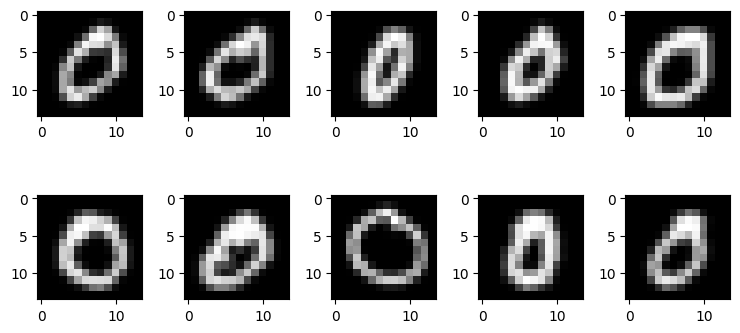

In [7]:
samples = [train_ds[i][0][0] for i in range(10)]
plot_mnist(samples, 2, 5)

In [11]:
flow = RealNVP(img_size * img_size, num_steps=num_transforms).to(device)
optim = torch.optim.AdamW(flow.parameters(), lr=lr)

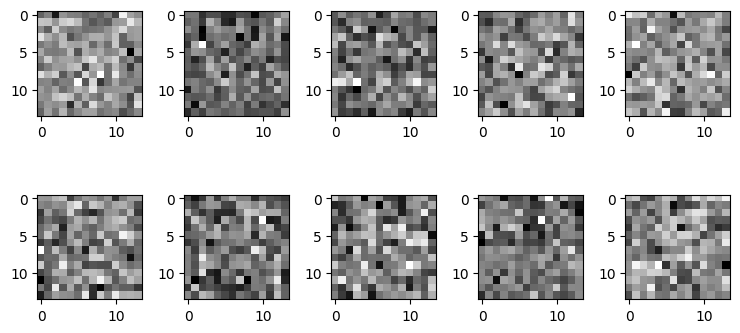

Epoch 1: Train Loss:1266.031026860719 Val BPD: 9.213794708251953


KeyboardInterrupt: 

In [12]:
num_samples_rows = 2
num_samples_cols = 5
for ep in range(epochs):
    total_loss = 0.
    iters = 0
    for x, _ in train_loader:
        x = (x * 255).long()
        u = torch.rand_like(x.float())
        x = x + u
        x = x / (2 ** bits)
        x = x.flatten(start_dim=1)

        optim.zero_grad()
        log_px = flow.log_prob(x.to(device)) - np.log((2 ** bits)) * (img_size * img_size)
        loss = - (log_px).mean()
        loss.backward()
        optim.step()
        iters += 1
        total_loss += loss.item()
    if ep % 10 == 0:
        flow.eval()
        with torch.no_grad():
            val_iters = 0
            total_bpd = 0.
            for x, _ in test_loader:
                x = (x * 255).long()
                u = torch.rand_like(x.float())
                x = x + u
                x = x / (2 ** bits)
                x = x.flatten(start_dim=1)
                log_px = flow.log_prob(x.to(device)) - np.log((2 ** bits)) * (img_size * img_size)
                bpd = -(log_px).mean().cpu() / (np.log(2) * (img_size * img_size))
                total_bpd += bpd
                val_iters += 1
        samples = flow.sample(num_samples_cols * num_samples_rows).detach().cpu()
        samples = torch.unflatten(samples, dim=1, sizes=(img_size, img_size))

        plot_mnist(samples, num_samples_rows, num_samples_cols)
        flow.train()
        print(f"Epoch {ep + 1}: Train Loss:{total_loss / iters} Val BPD: {total_bpd / val_iters}")